In [1]:
import json
import os
from pathlib import Path
import re
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.core.reference_space import ReferenceSpace

In [5]:
%matplotlib widget

# Load CCF info

I have been using the following resources to figure out how to use the AllenSDK to interact with the CCF:<br>
https://allensdk.readthedocs.io/en/latest/reference_space.html<br>https://allensdk.readthedocs.io/en/latest/connectivity.html<br>https://allensdk.readthedocs.io/en/latest/_static/examples/nb/mouse_connectivity.html<br>https://allensdk.readthedocs.io/en/latest/_static/examples/nb/reference_space.html#Downloading-an-annotation-volume

Also, this might be helpful when it comes to finding the reference coordinates:<br>https://community.brain-map.org/t/mouse-brain-reference-atlases-mapping-your-own-data/243

In [6]:
mcc = MouseConnectivityCache(resolution=25)
structure_tree = mcc.get_structure_tree()
mmpix = 0.025 # mm, we are using CCF with 25 um resolution for Tissuecyte
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# Load the subject list

In [7]:
data_dir = Path(r"P:\\")
save_dir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")

In [8]:
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100


## Loop through subjects

In [9]:
expCCFres = 25

In [10]:
stim_locations = []
for indi, exprow in all_subexp.iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.exp_folder))
    if not exprow.histology:
        print(" This subject doesn't have histology, skipping.\n")
        continue

    data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    # mcc = MouseConnectivityCache(resolution=expCCFres)
    # str_tree = mcc.get_structure_tree()
    # annot, annot_info = mcc.get_annotation_volume()

    ## Get coords for stim electrode ##
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
        tip_coords = np.array(stim_elec_data['tip']['ccf_coords'])
        surf_coords = np.array(stim_elec_data['surface']['ccf_coords'])
        stim_elec_vec = tip_coords - surf_coords
        norm = np.linalg.norm(stim_elec_vec)
        direction = stim_elec_vec / norm # unit vector
        other_tip_coords = (tip_coords - (exprow.stim_tip_distance / expCCFres) * direction).astype(int)
        other_tip_area = structure_tree.get_structures_by_id([annot[other_tip_coords[0], other_tip_coords[1], other_tip_coords[2]]])[0]['acronym']

        print(' Stim electrode location: {}\n'.format(stim_elec_data['tip']['area']))
        
        ## Store the position of the tips ##
        stim_locations.append([
            stim_elec_data['tip']['area'], tip_coords[0], tip_coords[1], tip_coords[2],
            other_tip_area, other_tip_coords[0], other_tip_coords[1], other_tip_coords[2],
            stim_elec_data['surface']['area'], surf_coords[0], surf_coords[1], surf_coords[2],
        ])
    else:
        print('Could not locate stim_elec_location.json.\n')

mouse771424: THstim_d1_2024-11-14_11-28-16
Experiment type: electrical stimulation
 Stim electrode location: TH

mouse771424: THstim_d2_2024-11-15_10-51-49
Experiment type: electrical stimulation
 Stim electrode location: CP

mouse771425: THstim_d1_2024-11-21_10-59-24
Experiment type: electrical stimulation
 Stim electrode location: PAL

mouse771425: THstim_d2_2024-11-22_10-49-58
Experiment type: electrical stimulation
 Stim electrode location: int

mouse771426: THstim_d1_2024-12-19_12-19-39
Experiment type: electrical stimulation
 Stim electrode location: AV

mouse771426: THstim_d2_2024-12-20_09-28-35
Experiment type: electrical stimulation
 Stim electrode location: AV

mouse771427: THstim_d1_2025-01-22_10-36-51
Experiment type: electrical stimulation
 Stim electrode location: DG-po

mouse771427: THstim_d2_2025-01-23_10-25-10
Experiment type: electrical stimulation
 Stim electrode location: CL

mouse771427: THstim_d3_2025-01-24_10-40-15
Experiment type: electrical and sensory stimulat

In [11]:
all_subexp[[
    'neg_tip_area', 'neg_tip_AP', 'neg_tip_DV', 'neg_tip_ML', 'pos_tip_area', 'pos_tip_AP', 'pos_tip_DV', 'pos_tip_ML',
    'surface_area', 'surface_AP', 'surface_DV', 'surface_ML'
]] = stim_locations

In [12]:
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,neg_tip_area,neg_tip_AP,neg_tip_DV,neg_tip_ML,pos_tip_area,pos_tip_AP,pos_tip_DV,pos_tip_ML,surface_area,surface_AP,surface_DV,surface_ML
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,243,144,169,fi,244,132,169,SSp-tr1,258,15,175
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,224,136,156,CP,225,124,158,SSp-ll1,237,21,176
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,231,160,167,CP,232,148,167,SSp-tr1,245,19,177
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,230,160,158,STR,231,148,159,SSp-tr1,247,18,175
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,243,140,189,AD,243,136,189,RSPagl1,258,15,195


## Look at single experiment

In [13]:
subind = 1
subrow = all_subexp.iloc[subind]
print(subrow)

mouse                                  mouse771424
sex                                              F
DOB                                            NaN
strain                                    C57BL/6J
exp_folder           THstim_d2_2024-11-15_10-51-49
histology                                     True
EEG                                          False
stim_tip_distance                              300
neg_tip_area                                    CP
neg_tip_AP                                     224
neg_tip_DV                                     136
neg_tip_ML                                     156
pos_tip_area                                    CP
pos_tip_AP                                     225
pos_tip_DV                                     124
pos_tip_ML                                     158
surface_area                               SSp-ll1
surface_AP                                     237
surface_DV                                      21
surface_ML                     

Text(0.5, 0.98, 'mouse771424: THstim_d2\nstim elec location: CP')

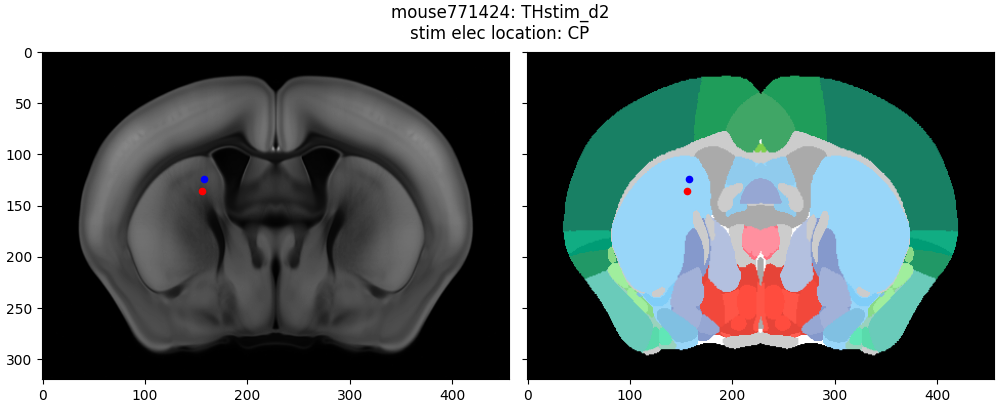

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True, sharex=True, sharey=True)

# tip, template #
axs[0].imshow(template[subrow.neg_tip_AP,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(subrow.neg_tip_ML, subrow.neg_tip_DV, s=20, c='r')
axs[0].scatter(subrow.pos_tip_ML, subrow.pos_tip_DV, s=20, c='b')

# tip, annot #
# axs[1].imshow(annot[tip_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_cmap = structure_tree.get_colormap()
ccf_cmap[0] = [0, 0, 0]
colim = np.reshape([ccf_cmap[point] for point in annot[subrow.neg_tip_AP,:,:].flat], list(annot[subrow.neg_tip_AP,:,:].shape) + [3]).astype(np.uint8)
axs[1].imshow(colim, aspect='equal')
axs[1].scatter(subrow.neg_tip_ML, subrow.neg_tip_DV, s=20, c='r')
axs[1].scatter(subrow.pos_tip_ML, subrow.pos_tip_DV, s=20, c='b')

plt.suptitle('{}: {}\nstim elec location: {}'.format(subrow.mouse, subrow.exp_folder[:9], subrow.neg_tip_area))

Try multiple experiments

In [15]:
ccf_cmap = structure_tree.get_colormap()
ccf_cmap[0] = [0, 0, 0]

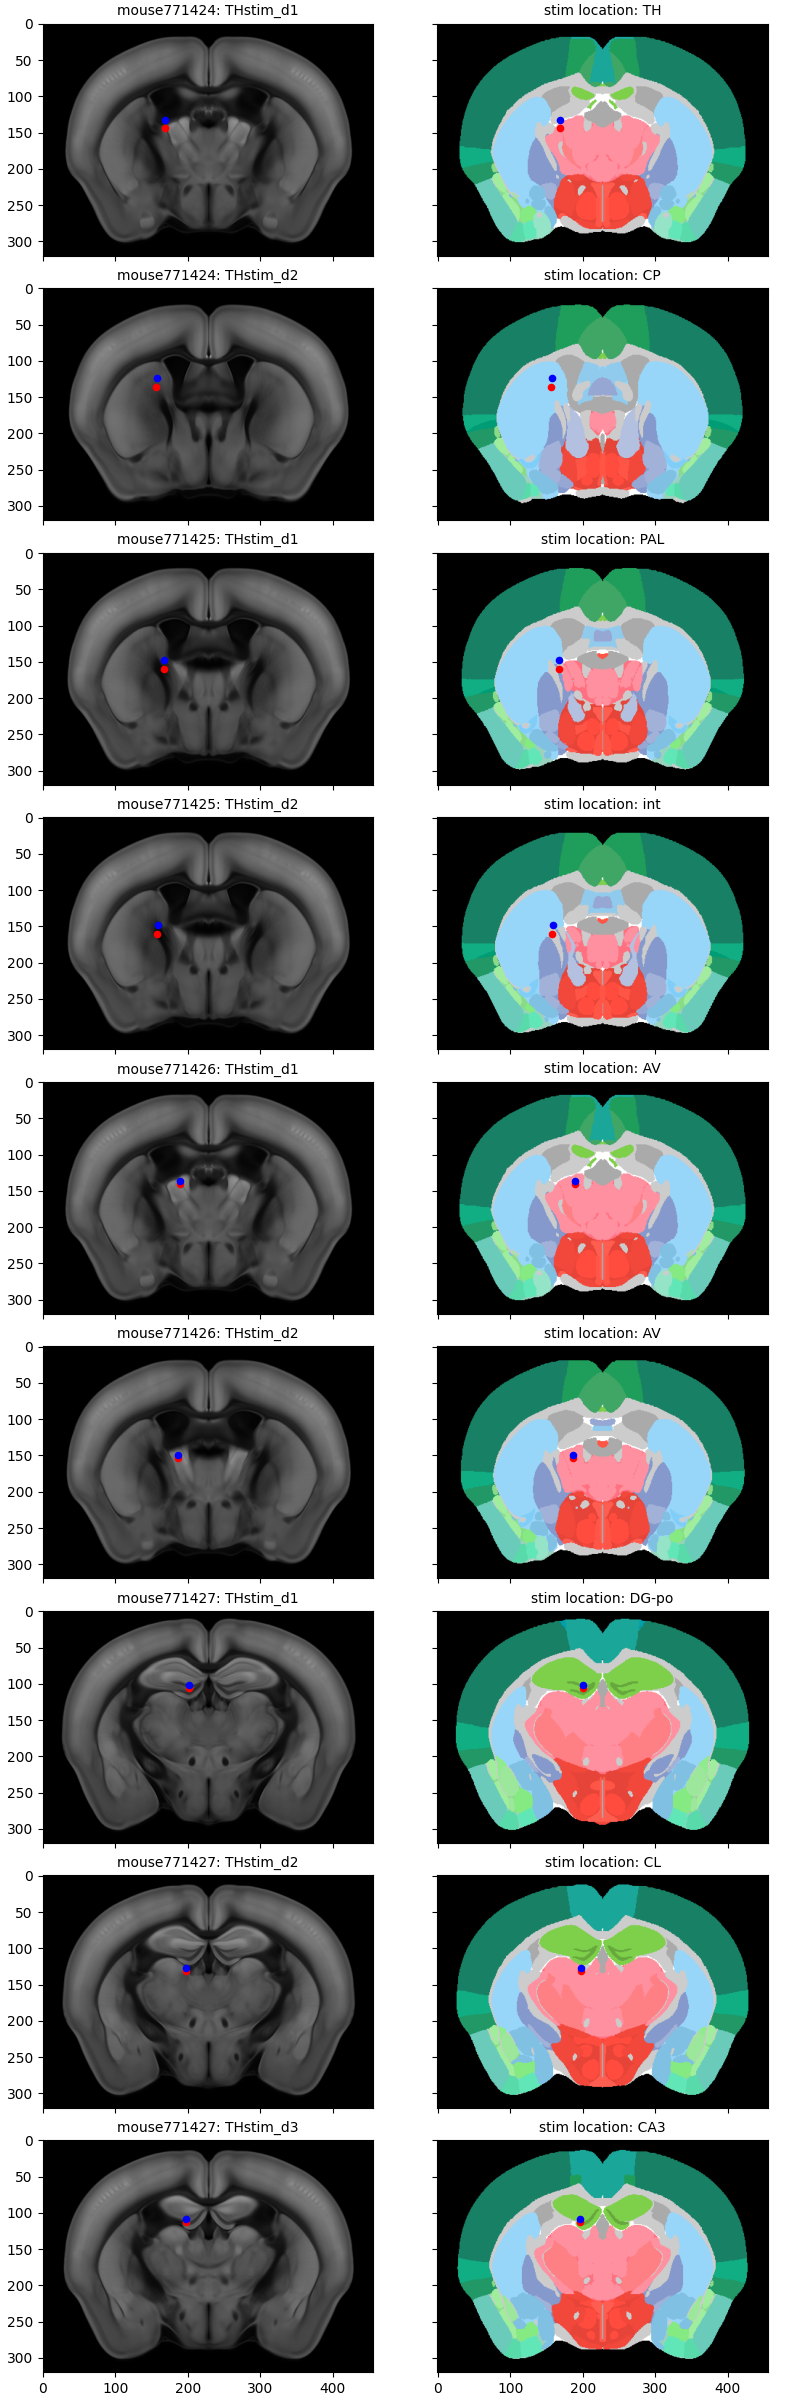

In [16]:
fig, axs = plt.subplots(len(all_subexp), 2, figsize=(8, 24), constrained_layout=True, sharex=True, sharey=True)
axi = 0
for indi, subrow in all_subexp.iterrows():
    # tip, template #
    axs[axi,0].imshow(template[subrow.neg_tip_AP,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
    axs[axi,0].scatter(subrow.neg_tip_ML, subrow.neg_tip_DV, s=20, c='r')
    axs[axi,0].scatter(subrow.pos_tip_ML, subrow.pos_tip_DV, s=20, c='b')

    # tip, annot #
    colim = np.reshape([ccf_cmap[point] for point in annot[subrow.neg_tip_AP,:,:].flat], list(annot[subrow.neg_tip_AP,:,:].shape) + [3]).astype(np.uint8)
    axs[axi,1].imshow(colim, aspect='equal')
    axs[axi,1].scatter(subrow.neg_tip_ML, subrow.neg_tip_DV, s=20, c='r')
    axs[axi,1].scatter(subrow.pos_tip_ML, subrow.pos_tip_DV, s=20, c='b')

    axs[axi,0].set_title('{}: {}'.format(subrow.mouse, subrow.exp_folder[:9]))
    axs[axi,1].set_title('stim location: {}'.format(subrow.neg_tip_area))

    axi += 1